<a href="https://colab.research.google.com/github/beifa/Bengali.AI/blob/master/AugMix_augmix_cutout_gridmax_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary
from torchvision import models, transforms
from PIL import Image
import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as FF
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH_RESIZE = '/content/drive/My Drive/Bengali/data/resize/'
PATH = '/content/drive/My Drive/Bengali/data/'
checkpoint = '/content/drive/My Drive/Bengali/checkpoint/'
#137x236 grayscale images

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls '/content/drive/My Drive/Bengali/data/resize/'

train_data_0_42.feather  train_data_1_64.feather  train_data_2_68.feather
train_data_0_64.feather  train_data_1_68.feather  train_data_3_42.feather
train_data_0_68.feather  train_data_2_42.feather  train_data_3_64.feather
train_data_1_42.feather  train_data_2_64.feather  train_data_3_68.feather


In [0]:
PATH_RESIZE = '/content/drive/My Drive/Bengali/data/resize/'
PATH = '/content/drive/My Drive/Bengali/data/'
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')
f0 = pd.read_feather(PATH_RESIZE + 'train_data_0_64.feather')
f1 = pd.read_feather(PATH_RESIZE + 'train_data_1_64.feather')
f2 = pd.read_feather(PATH_RESIZE + 'train_data_2_64.feather')
f3 = pd.read_feather(PATH_RESIZE + 'train_data_3_64.feather')

https://www.kaggle.com/haqishen/gridmask

https://www.kaggle.com/haqishen/augmix-based-on-albumentations

In [0]:
#all data
images = pd.concat([f0, f1, f2, f3], ignore_index = True)
del f0
del f1
del f2
del f3
gc.collect()

0

In [0]:
HEIGHT = 64
WIDTH = 64

class Dataset(Dataset):
  """
  data = img, parquet
  label = train.csv
  size = resize image for small size
  train = if train return label else only img 
  transform for change img

  """
  def __init__(self, data, label, train = 'train', transforms = None, albumentations = None):
      self.data = data
      self.label = label
      self.train = train        
      self.transforms = transforms
      self.albumentations = albumentations

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      img = self.data.iloc[idx][1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
      
      if self.transforms is not None:               
          img = self.transforms(img)                
      elif self.albumentations is not None:
          res = self.albumentations(image=img)
          img = res['image'].astype(np.float32)                
      else:
          img = img.astype(np.float32)
          
      img /= 255
      img = img[np.newaxis, :, :]
      img = 1 - img
      img = np.repeat(img, 3, 0)  # 1ch to 3ch
          
      if self.train == 'test':          
          return torch.tensor(img)  
      else:          
          lab1 = self.label.vowel_diacritic.values[idx]
          lab2 = self.label.grapheme_root.values[idx]
          lab3 = self.label.consonant_diacritic.values[idx]            
          return img, torch.tensor([lab1, lab2, lab3])      

In [0]:
class DoubleLinear(torch.nn.Module):
  def __init__(self, Linear1, Linear2, Linear3):
      super(DoubleLinear, self).__init__()
      self.Linear1 = Linear1
      self.Linear2 = Linear2
      self.Linear3 = Linear3

  def forward(self, input):
      return self.Linear1(input), self.Linear2(input), self.Linear3(input)
    
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


model = models.resnext50_32x4d(pretrained=False)

"""
feature_extract - это логическое значение, которое определяет,
выполняем ли мы тонкую настройку или извлечение функции. 
Если feature_extract = False, модель настраивается и все параметры модели обновляются. Если feature_extract = True,
обновляются только параметры последнего слоя, остальные остаются неизменными.

"""

feature_extract = False
set_parameter_requires_grad(model, feature_extract)
target1, target2, target3 = 11, 168, 7
#resnext50_32x4d
Linear_first = nn.Linear(2048, target1)
Linear_second = nn.Linear(2048, target2)
Linear_therd = nn.Linear(2048, target3)

model.fc = DoubleLinear(Linear_first, Linear_second, Linear_therd)

In [0]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 0, verbose=True)
criterion = nn.CrossEntropyLoss()

### cutmix

In [0]:
def ohem_loss( rate, cls_pred, cls_target ):

    batch_size = cls_pred.size(0) 
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate) )
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets
# loss 
def cutmix_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    # criterion = nn.CrossEntropyLoss(reduction='mean')
    criterion = ohem_loss
    return [lam * criterion(rate, preds1, targets1) + (1 - lam) * criterion(rate, preds1, targets2),
            lam * criterion(rate, preds2, targets3) + (1 - lam) * criterion(rate, preds2, targets4),
            lam * criterion(rate, preds3, targets5) + (1 - lam) * criterion(rate, preds3, targets6) ]


def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mixup_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    # criterion = nn.CrossEntropyLoss(reduction='mean')
    criterion = ohem_loss
    return [lam * criterion(rate, preds1, targets1) + (1 - lam) * criterion(rate, preds1, targets2),
            lam * criterion(rate, preds2, targets3) + (1 - lam) * criterion(rate, preds2, targets4),
            lam * criterion(rate, preds3, targets5) + (1 - lam) * criterion(rate, preds3, targets6) ]

### GridMask

In [0]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = FF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

### AugMix

In [0]:
from albumentations.core.transforms_interface import ImageOnlyTransform
from PIL import Image, ImageOps, ImageEnhance

def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

  def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
    super().__init__(always_apply, p)
    self.severity = severity
    self.width = width
    self.depth = depth
    self.alpha = alpha

  def apply(self, image, **params):
    image = augment_and_mix(
        image,
        self.severity,
        self.width,
        self.depth,
        self.alpha
    )
    return image

#Cutout

In [0]:
import torch
import numpy as np


class Cutout(object):
  """Randomly mask out one or more patches from an image.
  Args:
      n_holes (int): Number of patches to cut out of each image.
      length (int): The length (in pixels) of each square patch.
  """
  def __init__(self, n_holes, length):
    self.n_holes = n_holes
    self.length = length

  def __call__(self, img):
    """
    Args:
        img (Tensor): Tensor image of size (C, H, W).
    Returns:
        Tensor: Image with n_holes of dimension length x length cut out of it.
    """
    h = img.size(1)
    w = img.size(2)

    mask = np.ones((h, w), np.float32)

    for n in range(self.n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.

    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    img = img * mask

    return img

### Small test

In [0]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma,
    Rotate  )

In [0]:
tr = transforms.Compose([transforms.Resize([IMG_HEIGHT, IMG_WIDTH]),
                         transforms.RandomRotation(degrees=20),
                         transforms.ToTensor(),
                         Cutout(n_holes=3, length=65),
                         transforms.Normalize(MODEL_MEAN, MODEL_STD),
                         ])

torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])


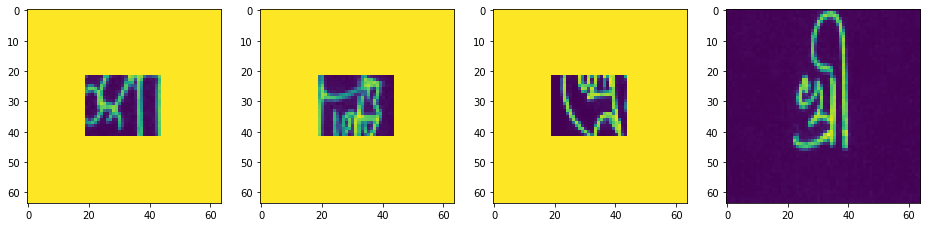

In [0]:
"""
собственно моя идея разделить на части и поскольку для меня cv,  работа с изображением в новинку
все, что смог так сказать, правда это не дало желаемых результатов, но я не успел все по тестить и вот я думаю, что ключевая проблема при
Crop, у меня только часть изображения(Crop) и в этом проблема
"""
tr = albumentations.Compose([
                             #OneOf([
                                    #Crop(40, 0, 64, 64, p = .25), #right
                                    #Crop(0, 0, 20, 64, p = .25), #left
                                    #Crop(0, 0, 64, 20, p= .4), #up
                                    Crop(20, 20, 45, 40, p =.6),#center

                                    #], p = .4),                             
                             PadIfNeeded(64, 64, border_mode=0),
                            
])
f0 = pd.read_feather(PATH_RESIZE + 'train_data_0_64.feather')
data = Dataset(f0.iloc[:10], train.iloc[:10], 'train', transforms = None, albumentations = tr)
dataloader = DataLoader(data, batch_size=10, shuffle=True)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8)) 
for i in range(4):
    #img, _ = data[i] # torch.Size([1, 64, 64])
    img, _ = next(iter(dataloader))    
    #print(img.shape)
    #ax[i].imshow(img.view(64, 64)) 
    print(img.shape)
    ax[i].imshow(img[0][0])

0
torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])


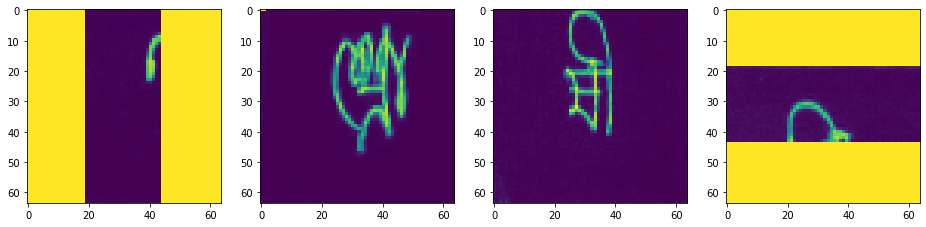

In [0]:
p = np.random.randn()
val = np.arange(1,6)
if p > 1:
  num  = np.random.choice(val)
else:
  num = 0
print(num)
tr = albumentations.Compose([
                             OneOf([
                                    Crop(40-num, 0, 64, 64, p = .25), #right
                                    Crop(0, 0, 25, 64, p = .25), #left
                                    Crop(0, 0, 64, 25-num, p= .4), #up
                                    Crop(20, 20, 45-num, 45+num, p =.6),#center

                                    ], p = .4),                             
                             PadIfNeeded(64, 64, border_mode=0),
                             OneOf([
                             
                                   Rotate(-5, border_mode=5, p=.2),
                                   Rotate(5, border_mode=5, p=.5),
                                   ], p = .2)    
])

f0 = pd.read_feather(PATH_RESIZE + 'train_data_0_64.feather')
data = Dataset(f0.iloc[:10], train.iloc[:10], 'train', transforms = None, albumentations = tr)
dataloader = DataLoader(data, batch_size=10, shuffle=True)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8)) 
for i in range(4):
    #img, _ = data[i] # torch.Size([1, 64, 64])
    img, _ = next(iter(dataloader))
    
    #print(img.shape)
    #ax[i].imshow(img.view(64, 64)) 
    print(img.shape)
    ax[i].imshow(img[0][0])

### Train

Это моя попытка сделать фолды для нн.
И чуть гугл не сломал, но так и не понял как "все" это делают.
И сделал по своему.

К концу этого соревнования и просмотрев кучу кода на гитхаба я допер, хотя я не уверен, просто размечаем трайн указав для каждого значения номер фолда

In [0]:
def split_data(img, target, seed = 13, num = 0.20):
  """
  ing = dataset  images
  target = train
  num = percent split
  return train and test 
  """
  spl = int(img.shape[0]*num)
  np.random.seed(seed)
  idx = np.arange(target.shape[0])
  np.random.shuffle(idx)  

  return img.iloc[idx[:-spl]], img.iloc[idx[:spl]], target.iloc[idx[:-spl]], target.iloc[idx[:spl]]

images_train, images_test, target_train, target_test= split_data(images, train, seed = 13, num = .20)

In [0]:
def stratifFolds(images_train, target_train):
  """
  images_target = images after split data
  target_train = target after split data
  summ we sum train grapheme for make splits
  return list idx split 
  """

  from sklearn.model_selection import StratifiedKFold
  skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)
  target_train['summ'] = target_train.iloc[:, [1,2,3]].sum(axis =1)
  spl = list(skf.split(images_train, target_train.summ))
  return spl

splits = stratifFolds(images_train, target_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
def plot_img(img):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8)) 
    num = 0
    for nr in range(3):
        for col in range(4):
            ax[nr][col].imshow(img[num][0].cpu().detach().numpy(), cmap='gray')
            num +=1
    plt.show()

In [0]:
#model.load_state_dict(torch.load(model.state_dict(),'resnext50_32x4d_20_64*64_sample5_batch64_nopre_AdamW_shulde_min_crop.pth'))
#model.load_state_dict(torch.load('resnext50_32x4d_20_64_64_sample5_batch64_nopre_AdamW_shulde_min_crop.pth'))

In [0]:
#not all data, sample
epochs = 50
BATCH_SIZE = 64
fold = [f'Fold_{i}' for i in range(4)]
index = pd.MultiIndex.from_product([
                            [0],
                            ['acc', 'loss', 'acc_val', 'loss_val']], names= ['Epoches', 'Statistics'] )
df = pd.DataFrame(columns=fold, index = index)

# tr = albumentations.Compose([
#     RandomAugMix(severity=7, width=7, alpha=5., p=1.),
#     #GridMask(num_grid=2, p=1),
#     GridMask(num_grid=1, rotate=15, mode=2,  p=1),
    
# ])

is_plot_m = True
is_plot_c = True
ALPHA = 0.8
for epoch in range(epochs): 
  print('epochs {}/{} '.format(epoch+1,epochs))
  print('================================')
  
  for i, (train_idx, valid_idx) in enumerate(splits):
    print(f'\nFold: {i + 1}\n')
  #   ################
    p = np.random.randn()
    val = np.arange(1,6)
    if p > 1:
      num  = np.random.choice(val)
    else:
      num = 0
    tr = albumentations.Compose([
                                
                                OneOf([
                                        # Crop(40-num, 0, 64, 64, p = .25), #right
                                        # Crop(0, 0, 25, 64, p = .25), #left
                                        Crop(0, 0, 64, 25-num, p= .4), #up
                                        Crop(20, 20, 45-num, 45+num, p =.6),#center
                                        ], p = .4),                             
                                PadIfNeeded(64, 64, border_mode=0),
                                OneOf([                                
                                      Rotate(-5, border_mode=5, p=.2),
                                      Rotate(5, border_mode=5, p=.5),
                                      ], p = .2)   
                                ])



    ###############    

    reduced_index = target_train.iloc[train_idx].groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(lambda x: x.sample(30)).image_id.values
    reduced_index_valid = target_train.iloc[valid_idx].groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(lambda x: x.sample(5)).image_id.values  

    running_loss = 0
    running_acc = 0.0
    valid_loss, valid_acc = 0, 0
    loss_mixup = 0
    loss_cutmix = 0
    to_do = {'train': reduced_index, 'valid': reduced_index_valid}
    for mark in to_do:
      reduced_train = target_train.loc[target_train.image_id.isin(to_do[mark])]
      reduced_data = images_train.loc[images_train.image_id.isin(to_do[mark])]
      #data = Dataset(reduced_data, reduced_train, train= 'train', transform=transf)
      data = Dataset(reduced_data, reduced_train, train= 'train', transforms = None, albumentations = None)  
      dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
      if mark == 'train':
          model.train()
      else:
          model.eval()

      for idx, (img, labels) in tqdm(enumerate(dataloader),total=len(dataloader)):         
          img = img.to(device)
          lab1 = labels[:, 0].to(device)
          lab2 = labels[:, 1].to(device)
          lab3 = labels[:, 2].to(device)
          
          
          
          ################################# add mixup and cutmix
          # is_mixup = False
          # is_cutmix = False
          # if mark == 'train':
          #     inits = np.random.rand()                    
          #     if inits < 0.3:                    
          #         img, targets = mixup(img, lab1, lab2, lab3, ALPHA)
          #         is_mixup = True
          #         if is_plot_m:                    
          #             plot_img(img)
          #             is_plot_m = False #plots ones
          #     elif (inits >= 0.3 and inits < 0.6):
          #         img, targets = cutmix(img, lab1, lab2, lab3, ALPHA)
          #         is_cutmix = True
          #         if is_plot_c:                    
          #             plot_img(img)
          #             is_plot_c = False #plots ones                        
              #################################              
          
          
          with torch.set_grad_enabled(mark == 'train'): #True, False is Cool
              outputs1,outputs2,outputs3 = model(img.float())                                      
              loss1 = criterion(outputs1,lab1)
              loss2 = criterion(outputs2,lab2)
              loss3 = criterion(outputs3,lab3)
              optimizer.zero_grad()

              if mark == 'train':
                  # if is_mixup:                            
                  #     loss = mixup_criterion(outputs1,outputs2,outputs3, targets)                             
                  #     loss_mixup += torch.stack(loss).sum().item()
                  # if is_cutmix:                            
                  #     loss = cutmix_criterion(outputs1,outputs2,outputs3, targets)
                  #     loss_cutmix += torch.stack(loss).sum().item()                           
                  #else:                            
                  running_loss += loss1+loss2+loss3        
                  running_acc += (outputs1.argmax(1)==lab1).float().mean()
                  running_acc += (outputs2.argmax(1)==lab2).float().mean()
                  running_acc += (outputs3.argmax(1)==lab3).float().mean()
              else:
                  valid_loss += loss1+loss2+loss3                         
                  valid_acc += (outputs1.argmax(1)==lab1).float().mean()
                  valid_acc += (outputs2.argmax(1)==lab2).float().mean()
                  valid_acc += (outputs3.argmax(1)==lab3).float().mean()                         
          
          if mark == 'train':
              # if is_mixup or is_cutmix:
              #     torch.stack(loss).sum().backward() 
              # else:
              (loss1+loss2+loss3).backward()                 
              optimizer.step()   
              #scheduler.step() #CyclicLR   

      if mark == 'train':
          df.loc[(epoch, 'acc'), fold[i]] = running_acc.item()/(len(dataloader)*3)
          df.loc[(epoch, 'loss'), fold[i]] = running_loss.item()/len(dataloader)      
      else:
          df.loc[(epoch, 'acc_val'), fold[i]] = valid_acc.item()/(len(dataloader)*3)
          df.loc[(epoch, 'loss_val'), fold[i]] = valid_loss.item()/len(dataloader) 

    print('\n--------------------------------------------------\n')
    scheduler.step(valid_loss) #mode min    
    acc, loss = running_acc/(len(dataloader)*3), running_loss/len(dataloader)
    acc_v, loss_v = valid_acc/(len(dataloader)*3),valid_loss/len(dataloader)   
    print('acc : {:.2f}%, loss : {:.4f},  Vla_acc : {:.2f}%, Val_loss : {:.4f}'.format(acc, loss, acc_v, loss_v))

In [0]:
torch.save(model.state_dict(),'resnext50_32x4d_50_64*64_sample5_batch64_nopre_AdamW_shulde_min_crop.pth')